# Time Series Forecasting with a Decision Tree

## getting the data

In [132]:
import pandas as pd
with open("../data/current_measurements.json") as file:
    df = pd.read_json(file)

## preparing a training and test set

In [133]:
df = df.iloc[::-1] # reverse the order, the data was ordered by DATE DESC, but we want the more recent data to be used in the test set
df['measuredAt'] = pd.to_datetime(df['measuredAt'])
df.index = df['measuredAt']
del(df['measuredAt'])

test_size = 0.2
lookback = 24

import numpy as np
dataset = df.humidity.values

In [134]:
# %load ../src/data/train_test.py
from sklearn.model_selection import train_test_split


def prepare_test_train(dataset, lookback, test_size=0.2):
    X, y = [], []
    for i in range(lookback, len(dataset) - lookback):
        X.append(dataset[i-lookback:i])
        y.append(dataset[i:i+lookback])
    return train_test_split(X, y, test_size=test_size, shuffle=False)


In [135]:
X_train, X_test, y_train, y_test = prepare_test_train(dataset, lookback, test_size)

## Training the Decision Tree Regressor

In [136]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [137]:
predicted_train = tree_reg.predict(X_train)
predicted_test = tree_reg.predict(X_test)

In [138]:
# %load ../src/visualization/plot_predictions.py
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 12


def prepare_plot_data(df, lookback, predicted_train, predicted_test, max_ahead=False):
    if max_ahead:
        offset = lookback * 2
        index = -1
    else:
        offset = lookback
        index = 0

    predicted_train_plot = []
    for i in range(0, predicted_train.shape[0]):
        predicted_train_plot = np.append(
            predicted_train_plot, predicted_train[i, index])

    predicted_test_plot = []
    for i in range(0, predicted_test.shape[0]):
        predicted_test_plot = np.append(
            predicted_test_plot, predicted_test[i, index])

    measured = df[offset:]
    plot_X_train = df.index[offset:len(predicted_train_plot) + offset]
    plot_X_test = df.index[offset + len(predicted_train_plot):offset + len(
        predicted_train_plot) + len(predicted_test_plot)]
    return measured, plot_X_train, predicted_train_plot, plot_X_test, predicted_test_plot


def visualize_predictions(df, lookback, predicted_train, predicted_test, show_measured=True, max_ahead=False, train_color="salmon", test_color="red", label="predicted"):
    measured, plot_X_train, plot_y_train, plot_X_test, plot_y_test = prepare_plot_data(
        df, lookback, predicted_train, predicted_test, max_ahead)
    plt.subplot()
    if show_measured:
        plt.plot(measured.index, measured.humidity, color="gray")
    plt.plot(plot_X_train, plot_y_train,
             color=train_color, label=label + " train")
    plt.plot(plot_X_test, plot_y_test, color=test_color, label=label + " test")
    plt.legend()


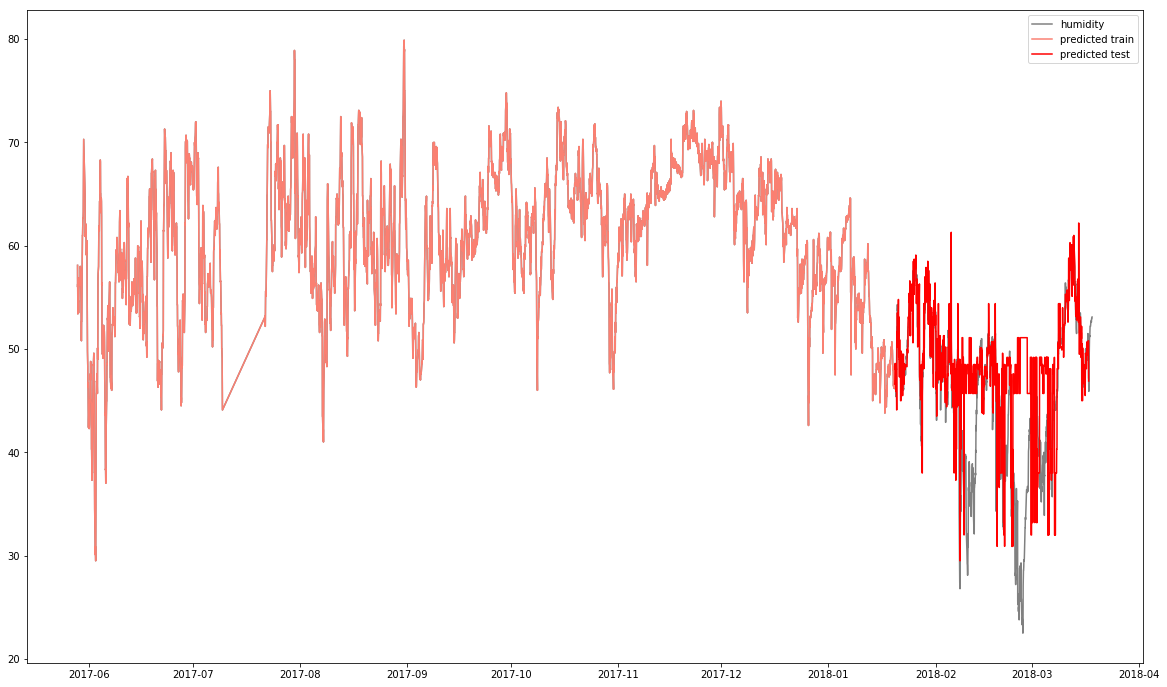

In [139]:
visualize_predictions(df, lookback, predicted_train, predicted_test)

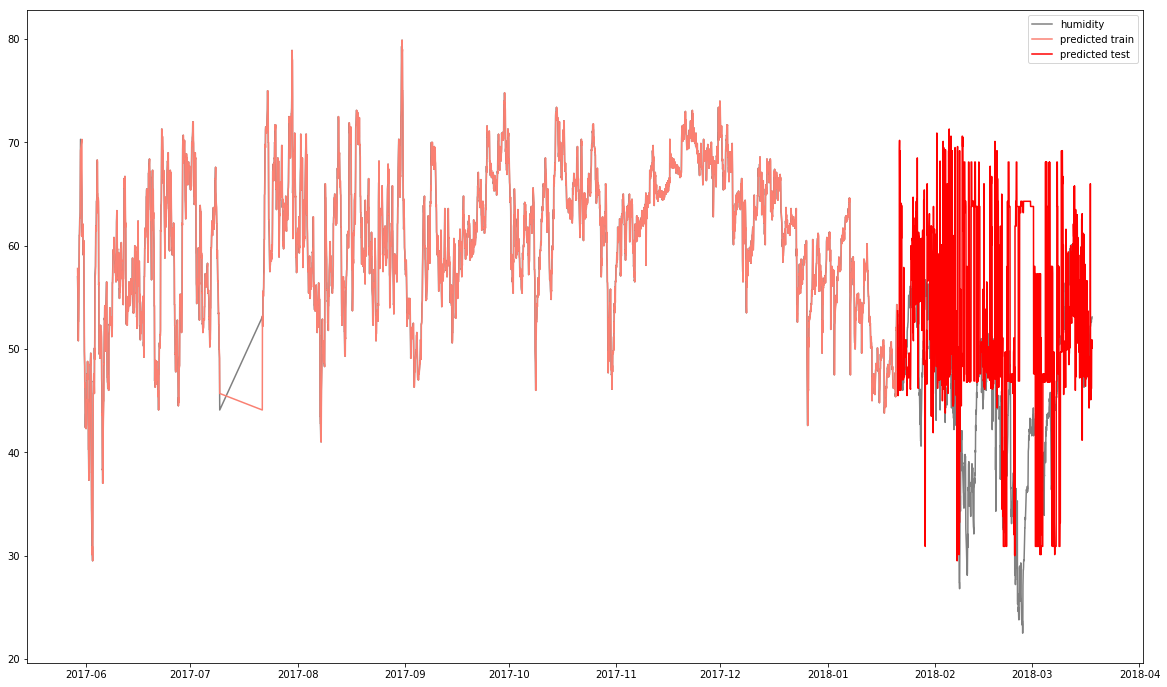

In [140]:
visualize_predictions(df, lookback, predicted_train, predicted_test, max_ahead=True)

/Users/oem/.pyenv/versions/3.6.3/envs/habitat/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


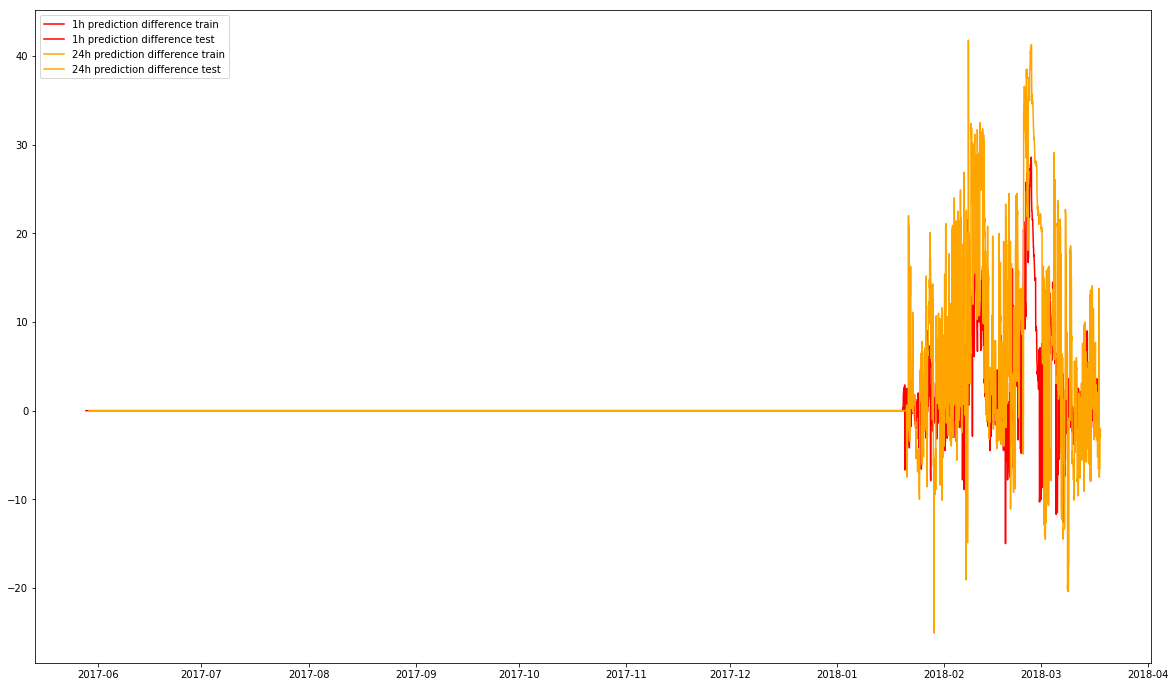

In [141]:
diff_train = np.subtract(predicted_train, y_train)
diff_test = np.subtract(predicted_test, y_test)

visualize_predictions(df, lookback, diff_train, diff_test, show_measured = False, label = "1h prediction difference", train_color = "red")
visualize_predictions(df, lookback, diff_train, diff_test, show_measured = False, max_ahead = True, label = "24h prediction difference", train_color = "orange", test_color = "orange")

In [142]:
# %load ../src/visualization/prediction_histogram.py
import numpy as np
import matplotlib.pylab as plt


def get_1h(t): return t[0]


def get_24h(t): return t[-1]


def plot_histograms(diff_train, diff_test):
    train_1h = np.array([get_1h(x) for x in diff_train])
    train_24h = np.array([get_24h(x) for x in diff_train])
    test_1h = np.array([get_1h(x) for x in diff_test])
    test_24h = np.array([get_24h(x) for x in diff_test])

    plt.hist(train_1h, color="blue",
             label="training set: predicted 1h difference")
    plt.hist(train_24h, color="violet", alpha=0.5,
             label="training set: predicted 24h difference")
    plt.legend()

    plt.figure()
    plt.hist(test_1h, color="orange",
             label="test set: predicted 1h difference")
    plt.hist(test_24h, color="yellow", alpha=0.5,
             label="test set: predicted 24h difference")
    plt.legend()

    plt.show()


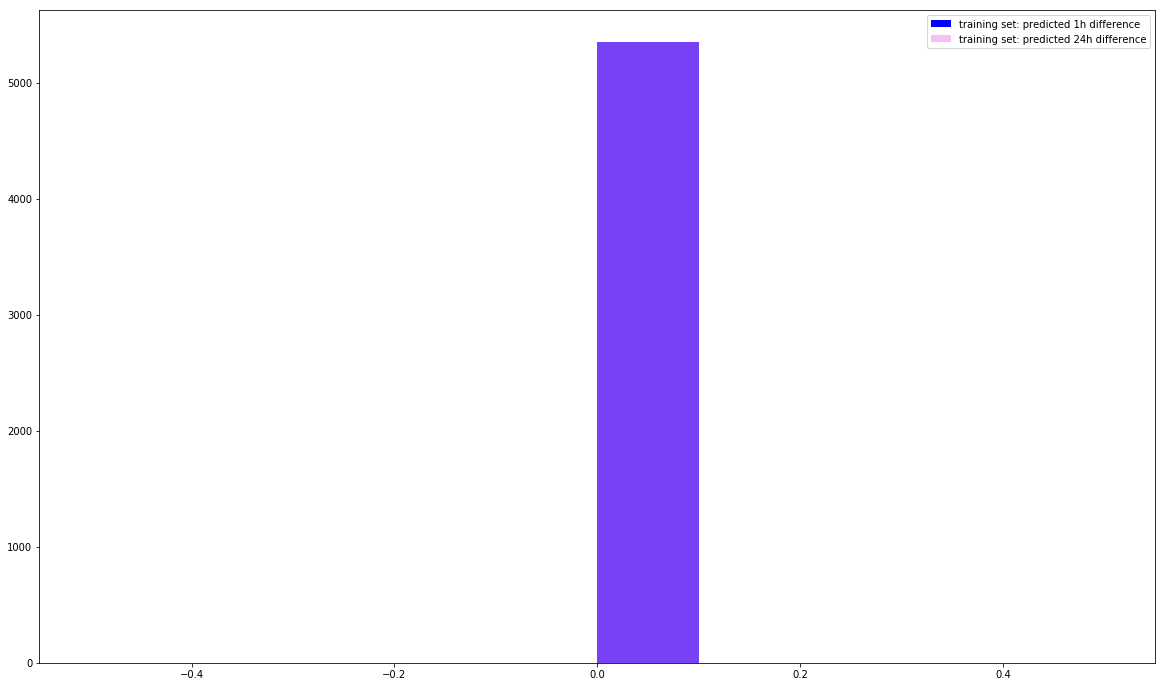

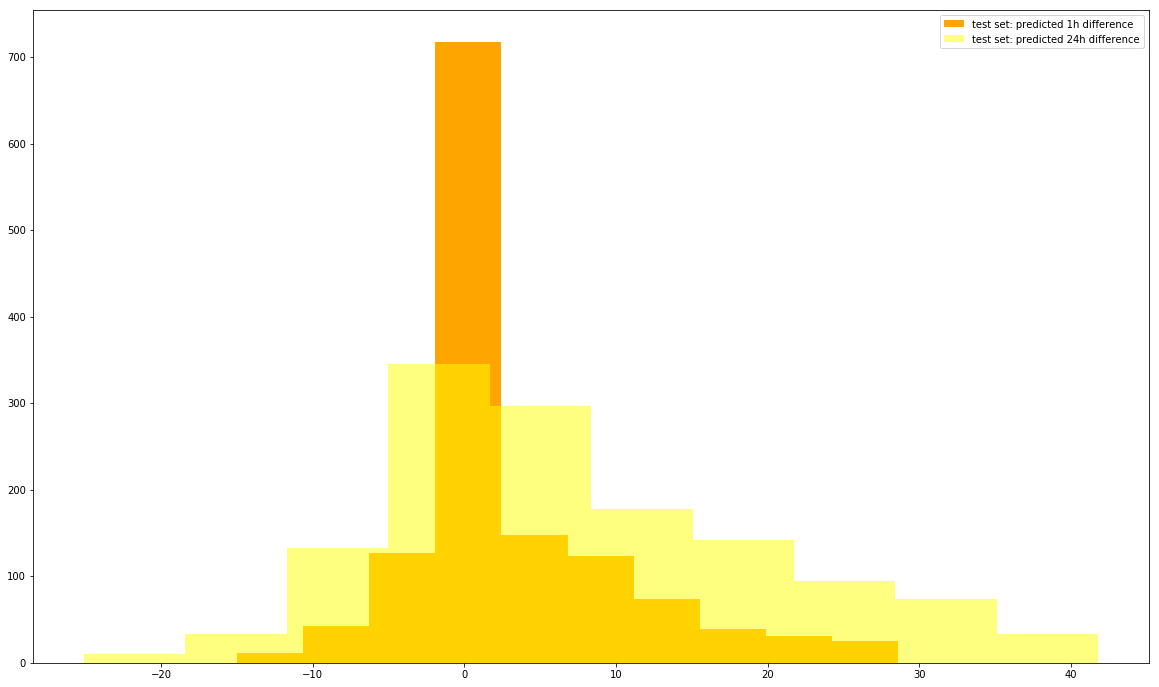

In [143]:
plot_histograms(diff_train, diff_test)

In [144]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse = math.sqrt(mean_squared_error(y_train, predicted_train))
test_rmse = math.sqrt(mean_squared_error(y_test, predicted_test))

print("RMSE on training set %.6f" % train_rmse)
print("RMSE on test set %.6f" % test_rmse)


print("MAE on training set %.6f" % mean_absolute_error(y_train, predicted_train))
print("MAE on test set %.6f" % mean_absolute_error(y_test, predicted_test))

RMSE on training set 0.000000
RMSE on test set 12.656247
MAE on training set 0.000000
MAE on test set 8.537341
